In [1]:
from pathlib import Path
import dicom_contour.contour as dcm
import pydicom as dicom
import os
import math
import numpy as np
from scipy.sparse import csc_matrix
from matplotlib import pyplot as plt

In [4]:
# read in a patient
# path = '/Users/salvatoreesposito/Downloads/Lung_dataset/manifest-1557326747206/LCTSC/LCTSC-Test-S2-201/04-12-1999-4D CT THORAX-92461/211.000000-Ave-IP10 0102030405060708090-93228'
path = '/Users/salvatoreesposito/Downloads/Lung_dataset/manifest-1557326747206/LCTSC/LCTSC-Test-S2-201/04-12-1999-4D CT THORAX-92461/211.000000-Ave-IP10 0102030405060708090-93228'

In [5]:
# get the contour file
def get_contour_file(path):
    '''
    Get contour file from the current path
    
    Input: 
    path (str) - the path that contains all the DICOM files
    
    Return: 
    contour_file (str) - the path of the contour file
    
    '''
    DicomFiles = []
    
    for (root, dirs, files) in os.walk(path):
        for filename in files:
            if ".dcm" in filename:
                DicomFiles.append(os.path.join(root, filename))
    
    n = 0
    for FileNames in DicomFiles:
        file = dicom.read_file(FileNames)
        if 'ROIContourSequence' in dir(file): # ROIContourSequence is the specific attribute for struc file
            contour_file = FileNames
            n = n + 1
    
    if n > 1:
        warnings.warn("There are more than one contour files, returning the last one!")
    
    return contour_file

In [6]:
# Get the contour file for the current patient:
contour_file = get_contour_file(path)
print(contour_file)

/Users/salvatoreesposito/Downloads/Lung_dataset/manifest-1557326747206/LCTSC/LCTSC-Test-S2-201/04-12-1999-4D CT THORAX-92461/211.000000-Ave-IP10 0102030405060708090-93228/1-1.dcm


In [7]:
dicom.read_file(contour_file)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 198
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Structure Set Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7014.4598.240397777200290823238930777304
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0012) Instance Creation Date              DA: '20110722'
(0008, 0013) Instance Creation Time              TM: '113416.679'
(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7014.4598.2

### Getting the right contour sequence

The contour file will embed information in a unstructured tree-like manner. After reading this Dicom file using `pydicom.read_file()`, we can see the nested structure. The contour file may contain different sequences, e.g. various contours from differnet experts.

In [8]:
contour_data = dicom.read_file(contour_file)
dcm.get_roi_names(contour_data)

['Esophagus', 'Heart', 'Lung_L', 'Lung_R', 'SpinalCord']

### Mapping contours into numpy array

we will use the 'right parotid' sequence (ROIcontourSeq = 0).

The contour information is embedded in cartesian coordinate points (x,y,z) in mm.


In [9]:
def cartesian2pixels(contour_dataset, path):
    '''
    Return image pixel array and contour label array given a contour dataset and the path 
    that contains the image files
    
    Inputs:
    contour_dataset - DICOM dataset class that is identified as (3006, 0016)  Contour Image Sequence
    path (str) - the path that contains all the Dicom files
    
    Return:
    ima_array - 2d numpy array of image with pixel intensities
    contour_array - 2d numpy array of contour with labels 0 and 1
    '''
    
    contour_coord = contour_dataset.ContourData
    
    # x, y, z coordinates of the contour in mm
    x0 = contour_coord[len(contour_coord)-3]
    y0 = contour_coord[len(contour_coord)-2]
    z0 = contour_coord[len(contour_coord)-1]
    coord = []
    for i in range(0, len(contour_coord), 3):
        x = contour_coord[i]
        y = contour_coord[i+1]
        z = contour_coord[i+2]
        l = math.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)
        l = math.ceil(l*2) + 1 # ceil: round toward positive infinity
        for j in range(1, l+1):
            coord.append([(x-x0)*j/l+x0, (y-y0)*j/l+y0, (z-z0)*j/l+z0])
        x0 = x
        y0 = y
        z0 = z
        
    # Extract the image id corresponding to given contour
    ima_file = []
    for (root, dirs, files) in os.walk(path):
        for filename in files:
            if ".dcm" in filename:
                if not "RD" in filename:
                    if not "RS" in filename:
                        ima_file.append(filename)
                        
    correspond_ima_file = []
    for FileNames in ima_file:
        f = dicom.read_file(path + '/' + FileNames)
        if f.SOPInstanceUID == contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID:
            correspond_ima_file.append(FileNames)
            
    
    # Read that Dicom image file
    ima = dicom.read_file(path + '/' + correspond_ima_file[0])
    ima_array = ima.pixel_array
    
    # Physical distance between the center of each pixel
    x_spacing = float(ima.PixelSpacing[0])
    y_spacing = float(ima.PixelSpacing[1])
    
    # The centre of the the upper left voxel
    origin_x = ima.ImagePositionPatient[0]
    origin_y = ima.ImagePositionPatient[1]
    origin_z = ima.ImagePositionPatient[2]
    
    # mapping
    pixel_coords = [(np.round((y - origin_y) / y_spacing), np.round((x-origin_x)/x_spacing)) for x, y, _ in coord]
    
    # get contour data for the image
    rows = []
    cols = []
    for i, j in list(set(pixel_coords)):
        rows.append(i)
        cols.append(j)
    contour_array = csc_matrix((np.ones_like(rows), (rows, cols)), dtype = np.int8, shape = (ima_array.shape[0], ima_array.shape[1])).toarray()
    
    return ima_array, contour_array, correspond_ima_file

In [10]:
def ContourImaArray(contour_file, path, ROIContourSeq = 0):
    '''
    Return the arrays of the contour and the corresponding images given the contour file and 
    the path of the images.

    Inputs:
    contour_file (str) - the path of the contour file
    path (str) - the path that contains all the Dicom files
    ROIContourSeq (int) - shows which sequence of contouring to use, default 5 (Rectum)

    Return:
    contour_ima_arrays (list) - a list that contains pairs of image pixel array and contour label array
    '''
    contour_data = dicom.read_file(contour_file)
    Rectum = contour_data.ROIContourSequence[ROIContourSeq]
    # get contour dataset in a list
    contours = [contour for contour in Rectum.ContourSequence]
    contour_ima_arrays = [cartesian2pixels(cdata, path) for cdata in contours]
    number_of_correspond_ima = len(contours)

    return contour_ima_arrays, number_of_correspond_ima

In [50]:
X=[]
y=[]
for i in range(7):
    contour_ima_arrays, number_of_correspond_ima = ContourImaArray(contour_file, path, ROIContourSeq = i)
    for j in range(len(contour_ima_arrays)):
        X.append(contour_ima_arrays[j][0])
        y.append(contour_ima_arrays[j][1])


[(array([[-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       ...,
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000]], dtype=int16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8), ['CT010073.dcm']), (array([[-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       ...,
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000]], dtype=int16), array([[0, 0, 0, ..., 0, 0, 0],
  

In [11]:
from tensorflow.keras import layers
import keras

def get_model(X, y):
    inputs = keras.Input(shape=[205,512,512])

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(2, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(X, y)
model.summary()


NameError: name 'X' is not defined

In [22]:
# Get all contour-image array pairs
contour_ima_arrays, number_of_correspond_ima = ContourImaArray(contour_file, path, ROIContourSeq = 1)
print(print(f"The number of slices that contain the chosen contour: {number_of_correspond_ima}\n"))
print(contour_ima_arrays)

The number of slices that contain the chosen contour: 29

None
[(array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8), ['10-002.dcm']), (array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -20

In [24]:
# Get first contour-image array
first_ima, first_contour, ima_id = contour_ima_arrays[10]


IndexError: list index out of range

In [ ]:
def fill_contours(arr):
    return np.maximum.accumulate(arr,1) & \
           np.maximum.accumulate(arr[:,::-1],1)[:,::-1]

first_contour=fill_contours(first_contour)

Text(0.5, 1.0, 'The corresponding contour of Slice: 12-004.dcm')

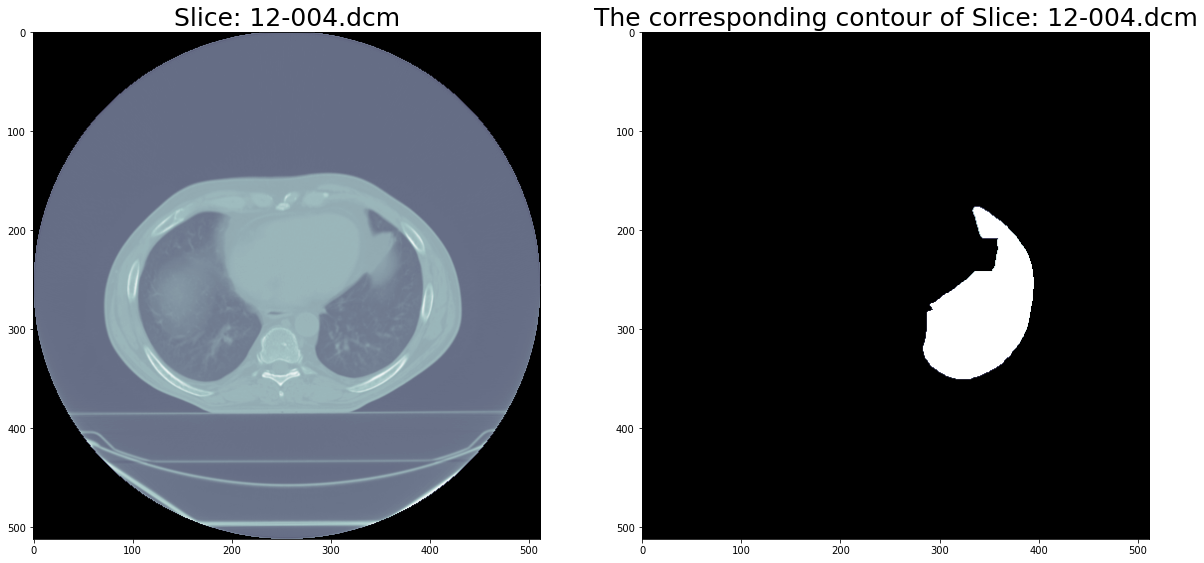

In [ ]:
# Show an example
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(first_ima, cmap = 'bone')
plt.title(f"Slice: {ima_id[0].split('/')[-1]}", fontsize = 25)
plt.subplot(1,2,2)
plt.imshow(first_contour, cmap = 'bone')
plt.title(f"The corresponding contour of Slice: {ima_id[0].split('/')[-1]}", fontsize = 25)

### Getting contour dictionary

get_contour_dict function is wrapper around ContourImaArray function which will return a dictionary. It will generate the ordered image-contour array pairs in order. It takes contour file and path of the folder containing .dcm files as well as the desired ROISequence index that we mentioned before and will return a dictionary of image filenames that are associated with a contour as keys and image-contour array pair as values.

In [33]:
def get_contour_dict(contour_file, path, ROIContourSeq):
    '''
    Return a dictionary as key: image filename, value: [corresponding image array, corresponding contour array]
    
    Input:
    contour_file (str) - contour file name
    path (str) - path contains all the Dicom files
    ROIContourSeq (int) - shows which sequence of contouring to use, default 5 (Rectum)
    
    Return:
    contour_dict: dictionary with 2d numpy array
    '''
    contour_list, _ = ContourImaArray(contour_file, path, ROIContourSeq)
    
    contour_dict = {}
    for ima_arr, contour_arr, ima_id in contour_list:
        contour_dict[ima_id[0]] = [ima_arr, contour_arr]
        
    return contour_dict
    

In [37]:
ROIContourSeq = 0
contour_dict = get_contour_dict(contour_file, path, ROIContourSeq)
print(contour_dict.keys())

dict_keys(['CT010073.dcm', 'CT010072.dcm', 'CT010071.dcm', 'CT010070.dcm', 'CT010069.dcm', 'CT010068.dcm', 'CT010066.dcm', 'CT010065.dcm', 'CT010064.dcm', 'CT010063.dcm', 'CT010062.dcm', 'CT010061.dcm', 'CT010060.dcm', 'CT010059.dcm', 'CT010058.dcm', 'CT010057.dcm', 'CT010055.dcm', 'CT010054.dcm', 'CT010053.dcm', 'CT010052.dcm', 'CT010051.dcm', 'CT010050.dcm', 'CT010049.dcm', 'CT010048.dcm', 'CT010047.dcm', 'CT010046.dcm', 'CT010044.dcm', 'CT010043.dcm', 'CT010042.dcm', 'CT010041.dcm', 'CT010040.dcm', 'CT010039.dcm', 'CT010038.dcm', 'CT010037.dcm', 'CT010036.dcm', 'CT010035.dcm', 'CT010033.dcm', 'CT010032.dcm', 'CT010031.dcm', 'CT010030.dcm', 'CT010029.dcm', 'CT010028.dcm', 'CT010027.dcm', 'CT010026.dcm', 'CT010025.dcm', 'CT010024.dcm', 'CT010022.dcm', 'CT010021.dcm', 'CT010020.dcm', 'CT010019.dcm', 'CT010018.dcm', 'CT010017.dcm', 'CT010016.dcm', 'CT010015.dcm', 'CT010014.dcm', 'CT010013.dcm', 'CT010011.dcm', 'CT010010.dcm', 'CT010009.dcm', 'CT010008.dcm', 'CT010007.dcm', 'CT010006.dcm

In [43]:
contour_dict["CT010033.dcm"][1].shape

(512, 512)

# Combine ALL

In [35]:
def order_slice(path):
    '''
    Return a list taht contains ordered image
    
    Input:
    path (str) - path that contains Dicom images
    
    Return:
    ordered_slices (dict) - ordered tuples of filename and z-position
    '''
    ImageFiles = []
    
    for (root, dirs, files) in os.walk(path):
        for filename in files:
            if ".dcm" in filename.lower():
                if not "RD" in filename:
                    if not "RS" in filename:
                        ImageFiles.append(filename)
                        
    ImageFiles.sort(key = lambda x: int(x[3:-4]))
    
    slices = [dicom.read_file(path + '/' + f) for f in ImageFiles]
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
        
    slice_dict =  {'CT_'+str(s.InstanceNumber)+'.dcm': s.ImagePositionPatient[2] for s in slices}
    ordered_slices = sorted(slice_dict.items(), key = lambda x:x[1], reverse = True)
    
    return ordered_slices
            

In [36]:
ordered_slice = order_slice(path)
ordered_slice[:10]

AttributeError: 'FileDataset' object has no attribute 'SliceLocation'

In [ ]:
def get_image_contour_files(path, ROISequence):
    '''
    Return a 3d array of images and corresponding 3d contours.
    
    Inputs: 
    path (str) - path that contains all the Dicom files
    ROIContourSeq (int) - shows which sequence of contouring to use, default 5 (Rectum)
    
    Return:
    images and contours np.arrays
    '''
    images = []
    contours = []
    
    # get contour file
    contour_file = get_contour_file(path)
    # get ordered slice
    ordered_slices = order_slice(path)
    # get contour dictionary
    contour_dict = get_contour_dict(contour_file, path, ROISequence)
    
    for key, value in ordered_slices:
        # get data from contour dict
        if key in contour_dict:
            images.append(contour_dict[key][0])
            contours.append(contour_dict[key][1])
        # get data from dicom.read_file
        else:
            ima_array = dicom.read_file(path + '/' + key).pixel_array
            contour_array = np.zeros_like(ima_array)
            images.append(ima_array)
            contours.append(contour_array)
            
    return np.array(images), np.array(contours)

In [ ]:
images, contours = get_image_contour_files(path, 0)

AttributeError: 'FileDataset' object has no attribute 'SliceLocation'

In [ ]:
images.shape, contours.shape

((31, 512, 512), (31, 512, 512))

In [ ]:
def plot2dcontour(ima_arr, contour_arr, figsize=(20, 20)):
    '''
    This function takes a single image array and contour array as input and shows the 
    actual image and its pair it's contour side by side.
    
    Inputs:
        img_arr - 2d np.array image array with pixel intensities
        contour_arr - 2d np.array contour array with pixels of 1 and 0
    '''

    masked_contour_arr = np.ma.masked_where(contour_arr == 0, contour_arr)
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(ima_arr, cmap='gray', interpolation='none')
    plt.subplot(1, 2, 2)
    plt.imshow(ima_arr, cmap='gray', interpolation='none')
    plt.imshow(masked_contour_arr, cmap='cool', interpolation='none', alpha=0.7)
    plt.show()

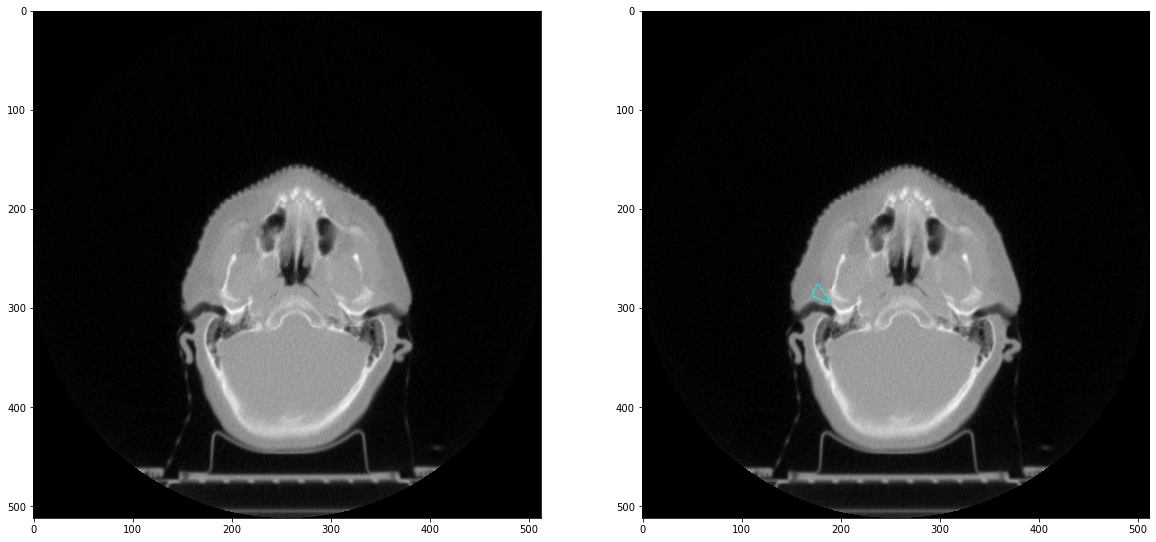

In [ ]:
for ima_arr, contour_arr in zip(images[0:1], contours[0:1]):
    plot2dcontour(ima_arr, contour_arr)